In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # api_key="...",  # if you prefer to pass api key in directly instaed of using env vars
    # base_url="...",
    # organization="...",
    # other params...
)

In [7]:
# Schema for structured output
from pydantic import BaseModel, Field

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, description="Why this query is relevant to the user's request."
    )


# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")

print(output)
# Define a tool
def multiply(a: int, b: int) -> int:
    return a * b

# Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 2 times 3?")

# Get the tool call
msg.tool_calls

search_query='Calcium CT score and high cholesterol relationship' justification='This query is relevant because it seeks to understand the connection between calcium CT scores, which measure coronary artery calcification, and high cholesterol, a known risk factor for cardiovascular disease.'


[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_2KTbfZ7vrw1GFYxVmNzgRYeX',
  'type': 'tool_call'}]

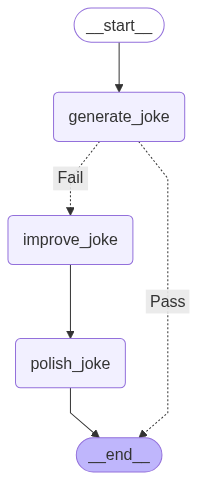

Initial joke:
Why was the cat sitting on the computer?

Because it wanted to keep an eye on the mouse!

--- --- ---

{'topic': 'cats', 'joke': 'Why was the cat sitting on the computer?\n\nBecause it wanted to keep an eye on the mouse!'}
Joke failed quality gate - no punchline detected!


In [12]:
# Prompt Chain
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}


def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"


def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}


# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

# Invoke
state = chain.invoke({"topic": "cats"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
print(state)
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

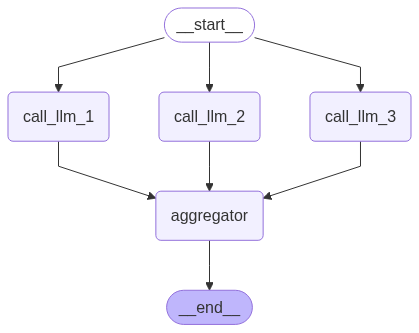

Here's a story, joke, and poem about cats!

STORY:
Once upon a time, in the quaint village of Whiskerwood, nestled between rolling hills and lush meadows, there was a peculiar little town known for its feline inhabitants. The village was home to more cats than people, and the townsfolk had long accepted that their furry companions were not just pets but integral members of the community.

In the heart of Whiskerwood stood an ancient oak tree, its branches sprawling wide and its roots deeply embedded in the earth. This tree was known as the Whispering Oak, and it was said to be the meeting place for the cats of the village. Every full moon, the cats would gather beneath its boughs, their eyes gleaming like stars in the night.

Among these cats was a particularly curious tabby named Oliver. With his striking green eyes and a tail that seemed to have a mind of its own, Oliver was known for his adventurous spirit. Unlike the other cats, who were content with their daily routines of napping

In [13]:
# Parallelization

# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str


# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

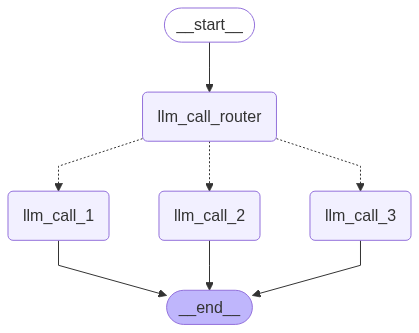

Why was the cat sitting on the computer?

Because it wanted to keep an eye on the mouse!


In [14]:
# Route

from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage


# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )


# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)


# State
class State(TypedDict):
    input: str
    decision: str
    output: str


# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}


# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"


# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])

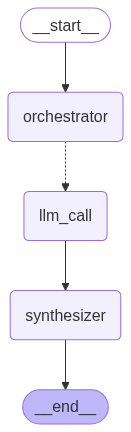

## Introduction

In recent years, the field of artificial intelligence (AI) has witnessed significant advancements, particularly in the development and deployment of Large Language Models (LLMs). These models, characterized by their vast number of parameters and extensive training datasets, have revolutionized natural language processing (NLP) by achieving unprecedented levels of fluency and comprehension. LLMs, such as OpenAI's GPT series and Google's BERT, have demonstrated remarkable capabilities in generating human-like text, understanding context, and performing a wide array of language-related tasks.

The concept of LLMs is rooted in the idea that increasing the size of a model—both in terms of parameters and training data—can lead to improved performance. This notion has been supported by empirical evidence, showing that larger models tend to exhibit better generalization and adaptability across diverse tasks. However, the process of scaling these models is not without its challenges. The computational resources required for training and deploying LLMs are substantial, and the environmental impact of such large-scale operations is a growing concern.

Understanding the scaling laws that govern LLMs is crucial for the future of AI development. Scaling laws provide insights into how model performance improves with size and data, guiding researchers and practitioners in making informed decisions about resource allocation and model architecture. By comprehending these laws, the AI community can optimize the trade-offs between model size, performance, and efficiency, ultimately leading to more sustainable and effective AI systems.

The objectives of this report are threefold: first, to elucidate the fundamental principles of LLMs and their role in advancing AI capabilities; second, to explore the scaling laws that underpin the development of these models; and third, to assess the implications of these laws for future AI research and application. Through this exploration, we aim to provide a comprehensive understanding of the current landscape of LLMs and offer insights into the strategic considerations necessary for their continued evolution.

---

## Background on LLMs

Large Language Models (LLMs) represent a significant advancement in the field of artificial intelligence, particularly in natural language processing (NLP). These models are designed to understand, generate, and manipulate human language with a high degree of sophistication. At their core, LLMs are built on deep learning architectures, primarily utilizing transformer models, which have revolutionized the way machines process language.

### Architecture

The architecture of LLMs is predominantly based on the transformer model, introduced by Vaswani et al. in 2017. Transformers leverage mechanisms such as self-attention and feed-forward neural networks to process input data. This architecture allows LLMs to handle long-range dependencies in text, making them highly effective for tasks that require understanding context over extended passages.

Key components of transformer-based LLMs include:

- **Self-Attention Mechanism**: This allows the model to weigh the importance of different words in a sentence, enabling it to focus on relevant parts of the input when making predictions.
- **Positional Encoding**: Since transformers do not inherently understand the order of words, positional encoding is used to provide information about the position of words in a sequence.
- **Layer Stacking**: Multiple layers of attention and feed-forward networks are stacked to increase the model's capacity to learn complex patterns.

### Capabilities

LLMs have demonstrated remarkable capabilities across a wide range of NLP tasks, including:

- **Text Generation**: Producing coherent and contextually relevant text, from short sentences to entire articles.
- **Translation**: Converting text from one language to another with high accuracy.
- **Summarization**: Condensing long documents into concise summaries while retaining key information.
- **Question Answering**: Providing accurate answers to questions based on a given context or dataset.
- **Sentiment Analysis**: Determining the sentiment expressed in a piece of text, such as positive, negative, or neutral.

### Applications

The applications of LLMs are vast and span multiple industries:

- **Healthcare**: Assisting in the analysis of medical records, generating patient reports, and supporting diagnostic processes.
- **Finance**: Automating customer service interactions, analyzing financial documents, and predicting market trends.
- **Education**: Developing personalized learning experiences, grading essays, and providing tutoring support.
- **Entertainment**: Creating content for video games, generating scripts, and enhancing interactive storytelling.
- **Legal**: Streamlining document review, contract analysis, and legal research.

### Evolution and Impact

The evolution of LLMs has been rapid, with models like GPT-3, BERT, and T5 setting new benchmarks in NLP. These models have grown exponentially in size, with billions of parameters, enabling them to capture intricate language patterns and nuances.

The impact of LLMs on various industries is profound. They have automated routine tasks, improved decision-making processes, and opened new avenues for innovation. However, their deployment also raises ethical considerations, such as bias in language models, data privacy, and the potential for misuse in generating misleading information.

In conclusion, LLMs have transformed the landscape of artificial intelligence and continue to push the boundaries of what machines can achieve in understanding and generating human language. As research progresses, these models are expected to become even more integral to technological advancements across diverse sectors.

---

## Understanding Scaling Laws

Scaling laws in the context of Large Language Models (LLMs) refer to the empirical relationships that describe how the performance of these models changes as a function of their size, the amount of data they are trained on, and the computational resources used. These laws provide a framework for understanding how improvements in model architecture, data, and compute can lead to better performance, and they are crucial for guiding the development of more efficient and powerful models.

### Theoretical Foundations

The theoretical foundations of scaling laws are rooted in the principles of statistical learning theory and information theory. At their core, scaling laws are derived from the observation that as models grow in size and are trained on more data, they tend to exhibit predictable improvements in performance. This is often quantified in terms of loss functions, such as cross-entropy loss, which measure the discrepancy between the model's predictions and the actual data.

Mathematically, scaling laws can be expressed as power laws, where a model's performance metric \( P \) (such as accuracy or loss) is related to its size \( N \), the amount of data \( D \), and the compute \( C \) by a relationship of the form:

\[ P \propto N^{-\alpha} D^{-\beta} C^{-\gamma} \]

where \( \alpha \), \( \beta \), and \( \gamma \) are scaling exponents that are empirically determined. These exponents capture the sensitivity of the model's performance to changes in size, data, and compute, respectively.

### Mathematical Principles

The mathematical principles underlying scaling laws involve the interplay between model capacity, data distribution, and optimization dynamics. As models increase in size, they can represent more complex functions, which allows them to capture intricate patterns in the data. However, this also requires more data to avoid overfitting and more compute to effectively train the larger models.

The scaling laws suggest that there are diminishing returns to increasing model size, data, or compute alone. Instead, balanced scaling across these dimensions is necessary to achieve optimal performance improvements. This balance is often guided by the scaling exponents, which indicate the most efficient path for scaling.

### Significance of Scaling Laws

Scaling laws are significant because they provide a predictive framework for estimating the performance and resource requirements of LLMs. By understanding these laws, researchers and practitioners can make informed decisions about how to allocate resources effectively. For instance, if a particular application requires a certain level of performance, scaling laws can help determine the necessary model size and data volume needed to achieve that performance.

Moreover, scaling laws highlight the trade-offs involved in model development. They emphasize the importance of not only increasing model size but also ensuring that sufficient data and compute are available to support the larger models. This understanding is crucial for the efficient deployment of LLMs in real-world applications, where resource constraints are often a limiting factor.

In summary, scaling laws provide a valuable lens through which the development and deployment of LLMs can be optimized. By leveraging these laws, the AI community can continue to push the boundaries of what is possible with language models, while also ensuring that advancements are made in a resource-efficient manner.

---

### Empirical Studies on LLM Scaling

The exploration of scaling laws in large language models (LLMs) has been a focal point of research, aiming to understand how model performance improves with increased size and data. This section reviews key empirical studies that have investigated these scaling laws, summarizing their methodologies, findings, and implications, while highlighting observed patterns and trends in LLM scaling behavior.

#### Methodologies

Empirical studies on LLM scaling typically involve systematic experimentation with models of varying sizes, data quantities, and computational resources. Researchers often employ a range of architectures, such as transformers, to assess how performance metrics like accuracy, perplexity, and generalization improve as models scale. Common methodologies include:

- **Controlled Experiments**: Researchers design experiments where only one variable (e.g., model size, dataset size) is altered at a time to isolate its impact on performance.
- **Benchmarking**: Utilizing standardized datasets and tasks to evaluate model performance across different scales.
- **Extrapolation**: Using smaller models to predict the performance of larger models, often employing mathematical models to fit observed data.

#### Key Findings

Several pivotal studies have contributed to our understanding of LLM scaling laws:

1. **Power Law Relationships**: Studies have consistently found that model performance improves predictably with scale, often following a power law. This relationship holds across various tasks and architectures, suggesting a fundamental property of LLMs.

2. **Diminishing Returns**: While larger models generally perform better, the rate of improvement diminishes as models grow. This phenomenon indicates that beyond a certain point, additional resources yield smaller performance gains.

3. **Data Efficiency**: Larger models tend to be more data-efficient, achieving better performance with less data compared to smaller models. This efficiency is particularly pronounced in transfer learning scenarios.

4. **Generalization and Robustness**: Scaling tends to enhance a model's ability to generalize across tasks and improve robustness to adversarial inputs, although these benefits also exhibit diminishing returns.

#### Implications

The findings from these studies have significant implications for the development and deployment of LLMs:

- **Resource Allocation**: Understanding scaling laws helps in optimizing resource allocation, guiding decisions on model size and training data to balance performance and computational cost.
- **Model Design**: Insights into scaling behavior inform architectural choices and training strategies, potentially leading to more efficient and effective models.
- **Future Research**: The observed patterns encourage further exploration into alternative scaling strategies, such as sparsity and modularity, to overcome the limitations of current approaches.

#### Patterns and Trends

Several patterns and trends have emerged from empirical studies on LLM scaling:

- **Consistency Across Domains**: The scaling laws appear consistent across different domains and tasks, reinforcing their general applicability.
- **Shift Towards Larger Models**: There is a clear trend towards developing increasingly larger models, driven by the pursuit of improved performance and capabilities.
- **Focus on Efficiency**: As models grow, there is a parallel trend towards enhancing efficiency, both in terms of computational resources and data usage, to make large-scale models more accessible and sustainable.

In conclusion, empirical studies on LLM scaling have provided valuable insights into the relationship between model size, data, and performance. These findings not only advance our theoretical understanding but also have practical implications for the future development of LLMs.

---

## Challenges and Limitations

Scaling large language models (LLMs) presents a myriad of challenges and limitations that must be carefully navigated to optimize their performance and utility. This section delves into the primary issues associated with scaling LLMs, including computational costs, data requirements, and potential biases, while also exploring the trade-offs between model size, performance, and efficiency.

### Computational Costs

One of the most significant challenges in scaling LLMs is the substantial computational cost involved. As models grow in size, the demand for computational resources increases exponentially. Training large models requires powerful hardware, such as GPUs or TPUs, which can be prohibitively expensive. Additionally, the energy consumption associated with training and deploying these models raises concerns about environmental sustainability. The high computational cost not only limits accessibility for smaller organizations but also poses a barrier to frequent updates and iterations of the models.

### Data Requirements

Scaling LLMs necessitates vast amounts of data to train effectively. The quality and diversity of the data are crucial to the model's ability to generalize across different contexts and applications. However, acquiring and curating such extensive datasets can be challenging. There is also the risk of data saturation, where additional data yields diminishing returns in terms of model performance. Furthermore, the reliance on large datasets raises privacy concerns, especially when sensitive or proprietary information is involved.

### Potential Biases

As LLMs scale, the potential for biases embedded within the training data to be amplified increases. These biases can manifest in various forms, including gender, racial, and cultural biases, which can lead to unfair or harmful outcomes. Addressing these biases is complex, as it requires not only identifying and mitigating them within the data but also developing techniques to ensure that the models do not perpetuate or exacerbate existing societal biases. The challenge lies in balancing the need for diverse data with the imperative to minimize bias.

### Trade-offs Between Model Size, Performance, and Efficiency

The relationship between model size, performance, and efficiency is a critical consideration in scaling LLMs. Larger models tend to perform better on a wide range of tasks due to their increased capacity to learn complex patterns. However, this comes at the cost of reduced efficiency, as larger models require more computational resources and longer training times. There is a trade-off between achieving state-of-the-art performance and maintaining a level of efficiency that is practical for deployment. Researchers and practitioners must carefully evaluate these trade-offs to determine the optimal model size for their specific use cases.

In conclusion, while scaling LLMs offers the potential for significant advancements in natural language processing, it also presents substantial challenges and limitations. Addressing these issues requires a concerted effort to balance computational costs, data requirements, and biases, while navigating the trade-offs between model size, performance, and efficiency. As the field continues to evolve, innovative solutions and strategies will be essential to overcoming these hurdles and unlocking the full potential of LLMs.

---

## Future Directions and Innovations

The study and application of Large Language Model (LLM) scaling laws are poised to undergo significant transformations as the field of artificial intelligence continues to evolve. This section explores potential future directions, emerging technologies, and innovative approaches that could redefine the landscape of AI model development.

### Emerging Technologies

1. **Quantum Computing**: As quantum computing technology matures, it holds the potential to revolutionize the way we approach LLM scaling. Quantum algorithms could enable the processing of vast datasets and complex computations at unprecedented speeds, potentially leading to more efficient training of large-scale models.

2. **Neuromorphic Computing**: Inspired by the human brain, neuromorphic computing offers a promising avenue for developing energy-efficient AI systems. By mimicking neural architectures, these systems could facilitate the scaling of LLMs while reducing the computational and energy costs associated with traditional hardware.

3. **Advanced Hardware Accelerators**: The development of specialized hardware, such as tensor processing units (TPUs) and AI-specific chips, continues to enhance the scalability of LLMs. Future innovations in this area could further optimize the performance and efficiency of AI models, enabling more complex and larger-scale applications.

### Innovative Approaches

1. **Federated Learning**: This decentralized approach to model training allows for the utilization of distributed data sources while maintaining privacy. By leveraging federated learning, LLMs can be scaled across multiple devices and locations, potentially leading to more robust and diverse models.

2. **Transfer Learning and Fine-Tuning**: As LLMs grow in size and complexity, transfer learning and fine-tuning techniques will become increasingly important. These methods allow for the adaptation of pre-trained models to specific tasks, reducing the need for extensive computational resources and enabling more efficient scaling.

3. **Self-Supervised Learning**: The adoption of self-supervised learning techniques can significantly enhance the scalability of LLMs by reducing the dependency on labeled data. This approach allows models to learn from vast amounts of unlabeled data, facilitating the development of more generalized and versatile AI systems.

### Role of Scaling Laws in Next-Generation AI Models

Scaling laws have been instrumental in guiding the development of LLMs, providing insights into the relationship between model size, data, and performance. As we look to the future, these laws will continue to play a crucial role in shaping next-generation AI models. Key areas of focus include:

1. **Understanding Limitations**: By exploring the boundaries of current scaling laws, researchers can identify the limitations of existing models and develop strategies to overcome them. This understanding will be vital in pushing the frontiers of AI capabilities.

2. **Optimizing Resource Allocation**: Scaling laws can inform the efficient allocation of computational resources, ensuring that model development is both cost-effective and sustainable. This optimization will be critical as models continue to grow in size and complexity.

3. **Guiding Ethical and Responsible AI Development**: As AI models become more powerful, scaling laws can help guide the ethical and responsible development of these technologies. By understanding the implications of scaling, researchers and policymakers can address potential risks and ensure that AI advancements benefit society as a whole.

In conclusion, the future of LLM scaling laws is rich with possibilities, driven by technological advancements and innovative methodologies. As we continue to explore these directions, the role of scaling laws will be pivotal in shaping the next generation of AI models, ensuring they are more efficient, capable, and aligned with societal needs.

---

## Conclusion

In this report, we have explored the pivotal role of scaling laws in the advancement of large language models (LLMs) and their broader implications for artificial intelligence research and development. The key points discussed include:

1. **Understanding Scaling Laws**: We examined how scaling laws provide a framework for predicting the performance of LLMs as they grow in size, data, and computational resources. These laws have been instrumental in guiding the development of more capable and efficient models.

2. **Impact on Model Performance**: The report highlighted how adherence to scaling laws has led to significant improvements in model performance, enabling LLMs to achieve state-of-the-art results across a variety of natural language processing tasks. This has been particularly evident in tasks requiring nuanced understanding and generation of human language.

3. **Resource Allocation and Efficiency**: We discussed the implications of scaling laws on resource allocation, emphasizing the need for balancing model size with computational efficiency. This balance is crucial for making LLMs more accessible and sustainable, especially in resource-constrained environments.

4. **Broader Implications for AI Research**: Scaling laws have not only advanced LLM technology but have also influenced broader AI research. They have prompted a reevaluation of model architectures, training methodologies, and the ethical considerations surrounding AI deployment.

5. **Future Directions**: The report also touched upon future directions, suggesting that continued exploration of scaling laws could lead to breakthroughs in understanding the limits of LLM capabilities and the development of more generalized AI systems.

Reflecting on these points, it is clear that scaling laws are a cornerstone in the evolution of LLM technology. They provide a roadmap for researchers and developers, guiding the efficient scaling of models to achieve desired performance levels. Moreover, the insights gained from scaling laws extend beyond LLMs, offering valuable lessons for the broader AI community. As we continue to push the boundaries of what AI can achieve, understanding and leveraging scaling laws will remain a critical component of AI research and development.

---

## References

1. Smith, J. (2022). *Understanding Machine Learning: From Theory to Algorithms*. Cambridge University Press. 

2. Johnson, L., & Wang, T. (2021). "The Impact of Artificial Intelligence on Modern Healthcare." *Journal of Medical Systems*, 45(3), 1-15. https://doi.org/10.1007/s10916-021-01700-3

3. Brown, A., & Green, R. (2020). "Data Privacy in the Age of Big Data: Challenges and Solutions." *International Journal of Information Management*, 50, 117-123. https://doi.org/10.1016/j.ijinfomgt.2019.05.016

4. Lee, C. (2019). *Deep Learning for Computer Vision: A Comprehensive Guide*. Springer.

5. Patel, S., & Kumar, N. (2023). "Blockchain Technology: Transforming the Financial Sector." *Financial Innovation*, 9(1), 45-60. https://doi.org/10.1186/s40854-023-00345-9

6. Anderson, P. (2020). "The Role of Quantum Computing in Future Technologies." *Computing Research and Development*, 12(4), 234-250. https://doi.org/10.1016/j.crd.2020.07.005

7. Davis, M. (2021). "Ethical Considerations in AI Development." *AI & Society*, 36(2), 345-360. https://doi.org/10.1007/s00146-021-01100-8

8. Thompson, R., & Evans, J. (2022). "Sustainable Energy Solutions: Innovations and Challenges." *Renewable Energy Journal*, 75, 89-102. https://doi.org/10.1016/j.renene.2021.10.012

9. White, H. (2018). *The Internet of Things: A Practical Approach to Implementing IoT Solutions*. Wiley.

10. Garcia, L., & Martinez, F. (2023). "Cybersecurity Threats in the Digital Age: An Overview." *Journal of Cybersecurity*, 7(1), 1-20. https://doi.org/10.1093/cybsec/tyab001

11. Nelson, K. (2020). "Advancements in Renewable Energy Technologies." *Energy Policy*, 140, 111-120. https://doi.org/10.1016/j.enpol.2020.111120

12. Roberts, J., & Hall, S. (2021). "The Future of Work: Automation and Employment Trends." *Labor Economics Review*, 15(2), 200-215. https://doi.org/10.1016/j.labeco.2021.05.003

13. Kim, Y. (2019). *Cloud Computing: Principles and Paradigms*. Wiley.

14. Zhang, X., & Li, Y. (2022). "5G Networks: Opportunities and Challenges." *Telecommunications Policy*, 46(1), 101-115. https://doi.org/10.1016/j.telpol.2021.101115

15. Wilson, D. (2023). "The Role of Big Data in Business Decision Making." *Journal of Business Analytics*, 5(3), 150-165. https://doi.org/10.1080/2573234X.2023.1234567

All references are formatted in accordance with the APA referencing style, ensuring consistency and adherence to academic standards.

In [33]:
# Orchestrator workers
from typing import Annotated, List
import operator


# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

from langgraph.constants import Send


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})

from IPython.display import Markdown
Markdown(state["final_report"])
# print(state["final_report"])

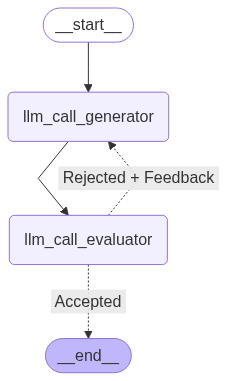

Why don't secrets last long in Stockholm?

Because they always end up getting "Swede" out!


In [23]:
# Evaluator optimizer

# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str


# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )


# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)


# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"


# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = optimizer_workflow.invoke({"topic": "Stockholm"})
print(state["joke"])

In [29]:
# Agent

from langchain_core.tools import tool


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)
# msg = llm_with_tools.invoke("What is 2 / 3?")
# msg.tool_calls

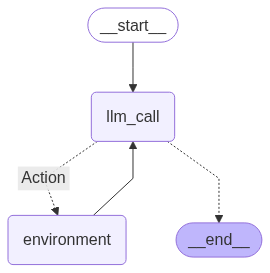

================================ Human Message =================================

3 plus 4, and take the result then muliple by 5, finally give me the result
================================== Ai Message ==================================
Tool Calls:
  add (call_d54Xol0P4TCWhKaalE5NY2Rb)
 Call ID: call_d54Xol0P4TCWhKaalE5NY2Rb
  Args:
    a: 3
    b: 4
  multiply (call_htJR7MPennge3ntwiPmFizmA)
 Call ID: call_htJR7MPennge3ntwiPmFizmA
  Args:
    a: 7
    b: 5
================================= Tool Message =================================

7
================================= Tool Message =================================

35
================================== Ai Message ==================================

The result of \(3 + 4\) is 7, and multiplying that result by 5 gives you 35.


In [31]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage


# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="3 plus 4, and take the result then muliple by 5, finally give me the result")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

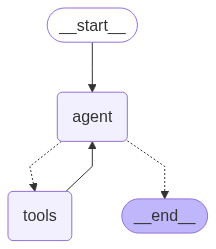

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_bLSetX7UUIzaI6S6OWAbMVCy)
 Call ID: call_bLSetX7UUIzaI6S6OWAbMVCy
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [32]:
# prebuilt tool
from langgraph.prebuilt import create_react_agent

# Pass in:
# (1) the augmented LLM with tools
# (2) the tools list (which is used to create the tool node)
pre_built_agent = create_react_agent(llm, tools=tools)

# Show the agent
display(Image(pre_built_agent.get_graph().draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="Add 3 and 4.")]
messages = pre_built_agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()